~~*POV: You just fked up a very important test but still have to do these stupid ass labs just like nothing happened…* <!--$\mathbb{T \omega T}$-->~~

### **NEVERMIND I DIDN'T!!!!!! LET'S GOOOOO!!!!!!!!!!!!**

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from IPython.display import clear_output

**(1)** Реализовать сигнал с единичными выбросами. Реализовать метод для исключения
выбросов в сигнале через порог стандартного отклонения. Представить очищенный сигнал.

In [2]:
def spiky_nd(A, degree):
    return np.abs(np.random.normal()**degree) * A

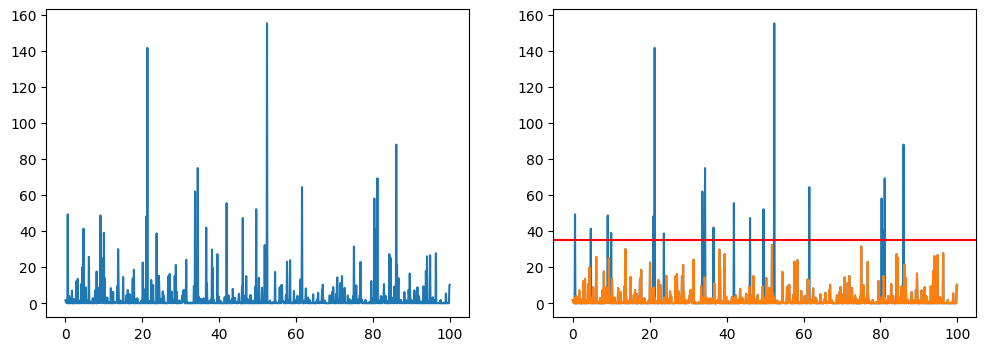

In [3]:
spiky_nd_time = np.arange(0, 100, 0.1)
spiky_nd_values = [spiky_nd(1, 4) for t in spiky_nd_time]


threshold = np.mean(spiky_nd_values) + 3 * np.std(spiky_nd_values)

spiky_nd_values_filtered = np.where(
    np.abs(spiky_nd_values) > threshold, np.mean(spiky_nd_values), spiky_nd_values
)


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(spiky_nd_time, spiky_nd_values)

plt.subplot(1, 2, 2)
plt.plot(spiky_nd_time, spiky_nd_values)
plt.plot(spiky_nd_time, spiky_nd_values_filtered)
plt.axhline(threshold, color='red')

plt.show()

<!-- ### –ноут (24-12-14) -->

**(2)** Реализовать сигнал, который содержит области с высоким уровнем шума. Это может быть
сделано путем добавления случайного шума к основному сигналу в определенных интервалах времени.

In [4]:
def funky_sinus(t, k, s, A):
    # return np.sin(t)*A
    np.random.seed(s + int(t//k))
    norm = np.random.normal(-A, A)
    np.random.seed()
    return norm + np.sin(s-t)

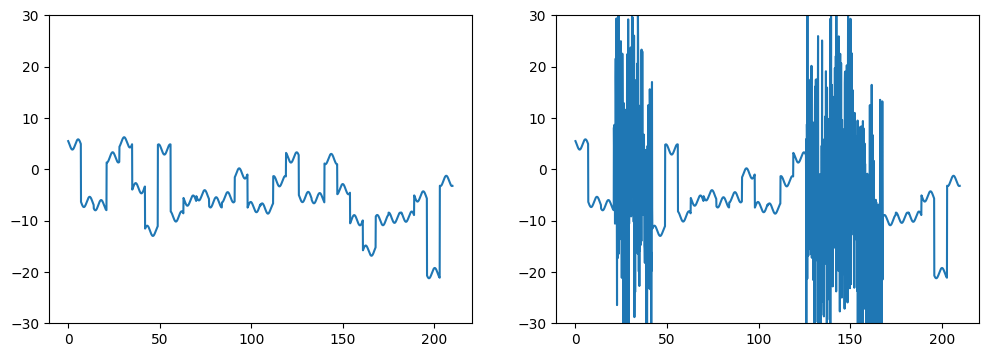

In [5]:
signal_time = np.arange(0, 210, 0.1)
signal_values = [funky_sinus(t, 7, 7, 7) for t in signal_time]

# А вот и наш зашумлённый сигнал!
signal_values_noisy = (
    signal_values[:int(0.1*len(signal_time))] +
    [t + np.random.normal(0, 14) for t in signal_values[int(0.1*len(signal_time)):int(0.2*len(signal_time))]] +
    signal_values[int(0.2*len(signal_time)):int(0.6*len(signal_time))] +
    [t + np.random.normal(0, 14) for t in signal_values[int(0.6*len(signal_time)):int(0.8*len(signal_time))]] +
    signal_values[int(0.8*len(signal_time)):]
)


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.ylim(-30, +30)
plt.plot(signal_time, signal_values)

plt.subplot(1, 2, 2)
plt.ylim(-30, +30)
plt.plot(signal_time, signal_values_noisy)

plt.show()

Напишите метод для очистки сигнала выше с помощью оконного скользящего
среднеквадратичного отклонения (Outlier time windows via sliding RMS). <!-- Код, кстати, из лекции, хехе… -->

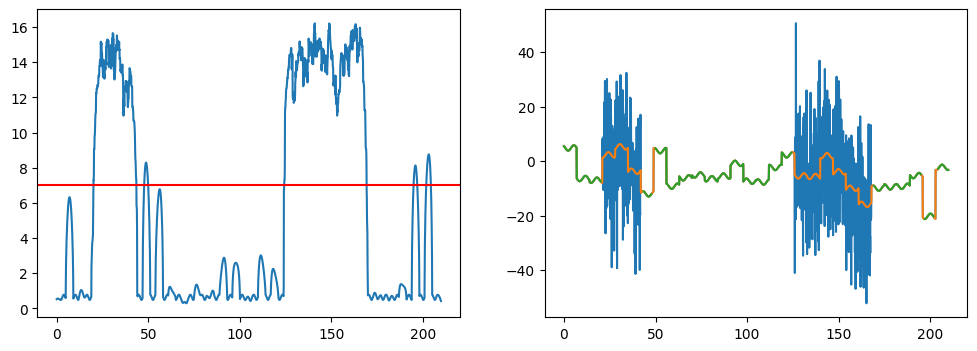

In [6]:
rms_window = 2 # Окно в процентах от времени
rms_window_idx = len(signal_time) * (rms_window / (2*100)) # Переводим окно в список индексов

# Инициализация вектора временного ряда RMS
rms_ts = np.zeros(len(signal_time))

# Проходимся окном по всему сигналу, определяем среднее  
for t_i in range(0, len(signal_time)):
    # Определяем индексы окна
    lb = int(np.max((0, int(t_i - rms_window_idx))))
    ub = int(np.min((len(signal_time), int(t_i + rms_window_idx))))

    # Считаем среднеквадратичное отклоение
    tmpsig = signal_values_noisy[lb:ub]
    tmpsig = tmpsig - np.mean(tmpsig)
    rms_ts[t_i] = np.sqrt(np.sum(tmpsig**2) / len(tmpsig))

thresh = 7 # Подбираем порог "на глаз"


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(signal_time, rms_ts)
plt.axhline(thresh, color='red')


# Вычисляем значения, отрезаемые порогом, и на их основе оставляем только "хорошие" значения
rms_ts_thresh = list(map(lambda a: a if a <= thresh else None, rms_ts))
signal_values_noisy_thresh = list(map(
    lambda i: signal_values_noisy[i] if rms_ts_thresh[i] is not None else None, range(len(rms_ts))
))


plt.subplot(1, 2, 2)
plt.plot(signal_time, signal_values_noisy)
plt.plot(signal_time, signal_values)
plt.plot(signal_time, signal_values_noisy_thresh)

plt.show()

Продолжаем мучить этот же сигнал:

**(3)** — Используя **метод спектральной интерполяции**, примерно восстановим вырезанные выше "плохие" части сигнала с удалёнными зашумлениями выше.

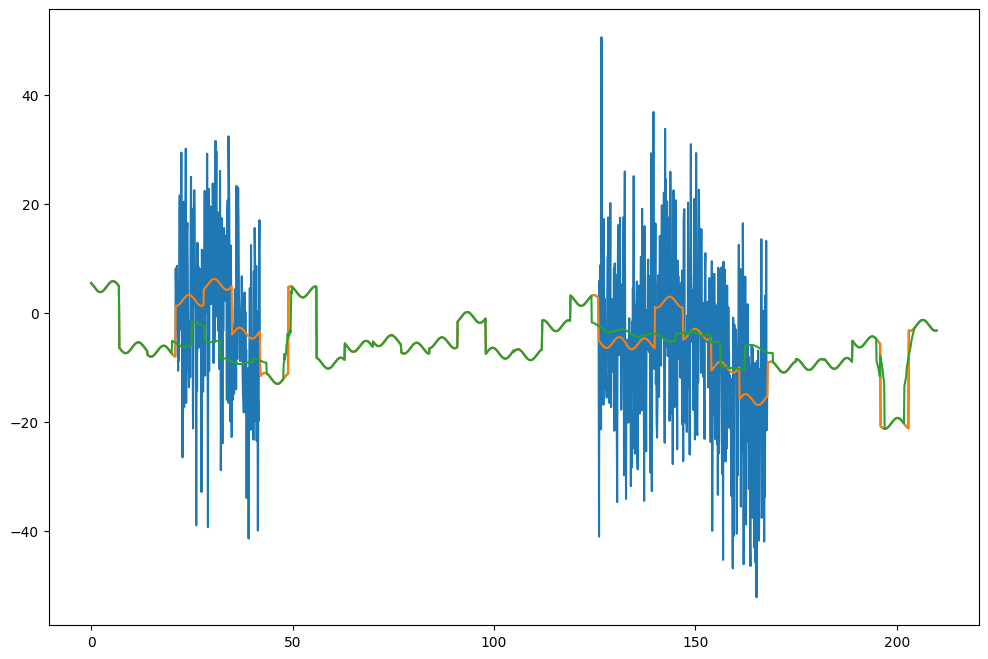

In [7]:
signal_values_restored = signal_values_noisy_thresh.copy()

si_window_size = 500 # Максимальный размер окна для анализа
si_corruption_start_idx = -1 # -1 если вне повреждённой части, иначе индекс начала повреждения

for i in range(len(signal_values_restored)):
    # Шаг 1: Найти индексы начала и конца разрыва сигнала
    if signal_values_restored[i] is None:
        if si_corruption_start_idx == -1:
            si_corruption_start_idx = i
    else:
        if si_corruption_start_idx != -1:
            # Шаг 2: Определяем окна до и после разрыва
            left_start = max(0, si_corruption_start_idx-si_window_size)
            left_end = si_corruption_start_idx
            right_start = i
            right_end = min(len(signal_values_restored), i + si_window_size)

            left_window = signal_values_restored[left_start:left_end]
            right_window = signal_values_restored[right_start:right_end]

            # Удаляем None и обрезаем окна по первому None
            left_clean = [val for val in left_window if val is not None]
            right_clean = [val for val in right_window if val is not None]

            # Обрезаем по минимальной длине
            min_len = min(len(left_clean), len(right_clean))
            left_clean = np.array(left_clean[:min_len])
            right_clean = np.array(right_clean[:min_len])

            # Шаг 3: FFT и усреднение спектров
            left_spectrum = np.fft.fft(left_clean)
            right_spectrum = np.fft.fft(right_clean)
            avg_spectrum = np.add(left_spectrum, right_spectrum) / 2

            restored_signal = np.fft.ifft(avg_spectrum).real
            if left_window[-1] < right_window[0]:
                restored_signal = np.flip(restored_signal)

            # Шаг 4: Линейная интерполяция
            interp_indices = np.linspace(0, len(restored_signal) - 1, i-si_corruption_start_idx)
            restored_gap = np.interp(interp_indices, np.arange(len(restored_signal)), restored_signal)
            restored_gap = np.add(restored_gap, np.linspace(left_window[-1], right_window[0], i-si_corruption_start_idx)) / 2

            signal_values_restored[si_corruption_start_idx:i] = restored_gap

            si_corruption_start_idx = -1


plt.figure(figsize=(12, 8))

plt.plot(signal_time, signal_values_noisy)
plt.plot(signal_time, signal_values)
plt.plot(signal_time, signal_values_restored)

plt.show()

[*«День уже минає, наступає ніч»*](https://www.youtube.com/watch?v=cMMKv51HbbU)

---

**(4) Алгоритм понижения/повышения дискретности сигнала в N раз.**

*Зачем-то это вынесено в отдельное задание, но удобнее делать его сразу на ходу со следующим:*

**(5)** В результате записи сигналов с 3-х различных датчиков были записаны данные с различной частотой
дискретизации. Привести все сигналы к единой частоте дискретизации. В качестве сигналов можно выбрать три косинуса с различной частотой дискретизации, например 10, 35 и 80 Гц.

In [8]:
def cosinus(t, k, A):
    return np.cos(t*k) * A

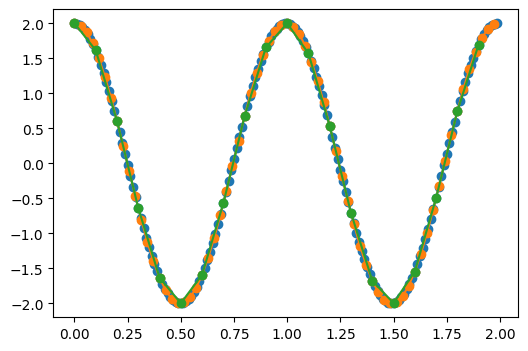

In [9]:
cosinus10_time = np.arange(0, 2, (1/10))
cosinus35_time = np.arange(0, 2, (1/35))
cosinus80_time = np.arange(0, 2, (1/80))

cosinus10_values = [cosinus(t, 6.32, 2) for t in cosinus10_time]
cosinus35_values = [cosinus(t, 6.32, 2) for t in cosinus35_time]
cosinus80_values = [cosinus(t, 6.32, 2) for t in cosinus80_time]


plt.figure(figsize=(6, 4))

plt.plot(cosinus80_time, cosinus80_values, marker='o')
plt.plot(cosinus35_time, cosinus35_values, marker='o')
plt.plot(cosinus10_time, cosinus10_values, marker='o')

plt.show()

Повышение дискретизации происходит просто через повышение числа точек путём интерполяции:

In [10]:
def upsample(signal_orig, N):
    time_orig = np.arange(0, 1, 1/len(signal_orig)) # Нам пофиг, как конкретно идёт время
    time_new = np.arange(0, 1, 1/(len(signal_orig) * N)) # Главное, изобразить увеличение числа точек

    # print(len(time_orig), len(signal_orig))

    signal_new = np.interp(time_new, time_orig, signal_orig) # "Растягиваем" изначальный сигнал
    return signal_new

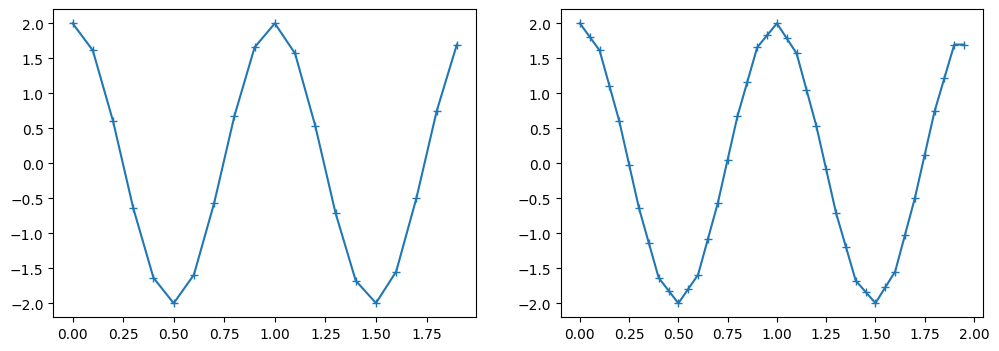

In [11]:
cosinus10_values_x2 = upsample(cosinus10_values, 2)

cosinus10_time_x2 = np.linspace(0, 2, len(cosinus10_values_x2), endpoint=False)


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cosinus10_time, cosinus10_values, marker='+')

plt.subplot(1, 2, 2)
plt.plot(cosinus10_time_x2, cosinus10_values_x2, marker='+')

plt.show()

Понижение дискретизации сигнала же происходит несколько сложнее:

```bash
Proper downsampling:
1. Pick new sampling rate
2. Low-pass filter at new Nyquist
3. Downsample
```

**Почему так?** Чтобы не допустить [алиасинга](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B8%D0%B0%D1%81%D0%B8%D0%BD%D0%B3) — наложения частот $f > f_s/2$ на частоты $f < f_s/2$, из-за чего при восстановлении сигнала будет происходить его искажение — чего, правда, в моём случае этого произойти не может, потому что спектр сигнала, состоящего только из чистых косинусов (без шумов), состоит всего лишь из одного пика, да и тот лежит за пределами частоты Найквиста, причём что оригинальной, что новой.

In [12]:
# См. "filters.ipynb", пункт 6.

def butterwort_lofreq_nth(n, w, w_c):
    imag = (w / w_c)
    real = (0 / w_c) # Нет затухающих частот --> Действительную часть фильтра Баттерворта можно отбросить
    S = real + 1j * imag
    
    return (1 / (1 + (-1)**n * (S)**(2*n)))

In [13]:
def downsample(signal_orig, disc_orig, N):
    # Частота Найквиста = 1/2 частоты дискретизации
    nyquist_orig = disc_orig / 2
    nyquist_new = (disc_orig / N) / 2

    signal_orig_freq = np.fft.fftfreq(len(signal_orig), 1/disc_orig)
    signal_orig_fft = np.fft.fft(signal_orig)

    filter_lofreq = butterwort_lofreq_nth(10, signal_orig_freq, nyquist_new)

    signal_filtered_fft = signal_orig_fft * filter_lofreq
    signal_filtered = np.fft.ifft(signal_filtered_fft)

    time_orig = np.arange(0, 1, 1/len(signal_filtered.real)) # Нам пофиг, как конкретно идёт время
    time_new = np.arange(0, 1, 1/(len(signal_filtered.real) / N)) # Главное, изобразить увеличение числа точек

    signal_new = np.interp(time_new, time_orig, signal_filtered.real) # "Растягиваем" изначальный сигнал
    return signal_new

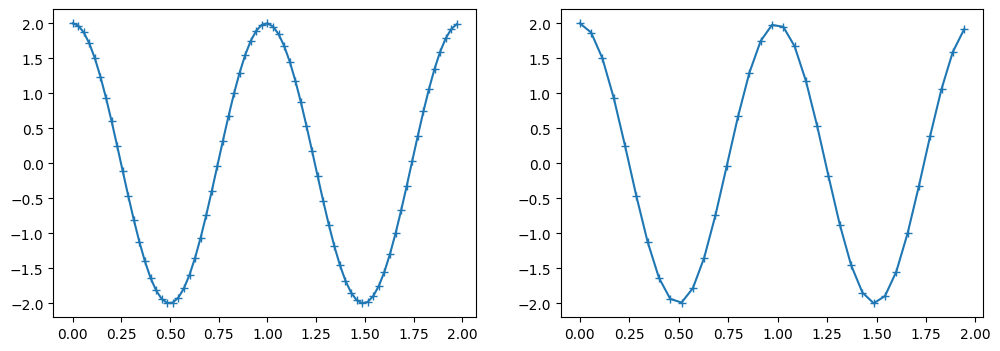

In [14]:
cosinus35_values_x05 = downsample(cosinus35_values, (1/35), 2)

cosinus35_time_x05 = np.linspace(0, 2, len(cosinus35_values_x05), endpoint=False)


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cosinus35_time, cosinus35_values, marker='+')

plt.subplot(1, 2, 2)
plt.plot(cosinus35_time_x05, cosinus35_values_x05, marker='+')

plt.show()

А теперь, собственно, выполним условие задания — приведём все три сигнала к какой-нибудь новой частоте:

In [15]:
def upsample_or_downsample(signal_orig, disc_orig, disc_new):
    if disc_orig < disc_new:
        return downsample(signal_orig, disc_orig, (disc_new / disc_orig))
    elif disc_orig > disc_new:
        return upsample(signal_orig, (disc_orig / disc_new))
    else:
        return signal_orig

In [16]:
def mega_rzhaka(N):
    cosinus10_values_xN = upsample_or_downsample(cosinus10_values, 1/10, 1/N)
    cosinus35_values_xN = upsample_or_downsample(cosinus35_values, 1/35, 1/N)
    cosinus80_values_xN = upsample_or_downsample(cosinus80_values, 1/80, 1/N)

    cosinus10_time_xN = np.linspace(0, 2, len(cosinus10_values_xN), endpoint=False)
    cosinus35_time_xN = np.linspace(0, 2, len(cosinus35_values_xN), endpoint=False)
    cosinus80_time_xN = np.linspace(0, 2, len(cosinus80_values_xN), endpoint=False)

    print(len(cosinus10_values), len(cosinus35_values), len(cosinus80_values))
    print('-->')
    print(len(cosinus10_values_xN), len(cosinus35_values_xN), len(cosinus80_values_xN))


    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(cosinus80_time, cosinus80_values, marker='+')
    plt.plot(cosinus35_time, cosinus35_values, marker='+')
    plt.plot(cosinus10_time, cosinus10_values, marker='+')
    plt.title('Оригинальные частоты дисркетизации')

    plt.subplot(1, 2, 2)
    plt.plot(cosinus80_time_xN, cosinus80_values_xN, marker='+')
    plt.plot(cosinus35_time_xN, cosinus35_values_xN, marker='+')
    plt.plot(cosinus10_time_xN, cosinus10_values_xN, marker='+')
    plt.title(f'Единая частота дискретизации $N = {N}$')

    plt.show()
    clear_output(wait=True)

20 70 160
-->
40 40 40


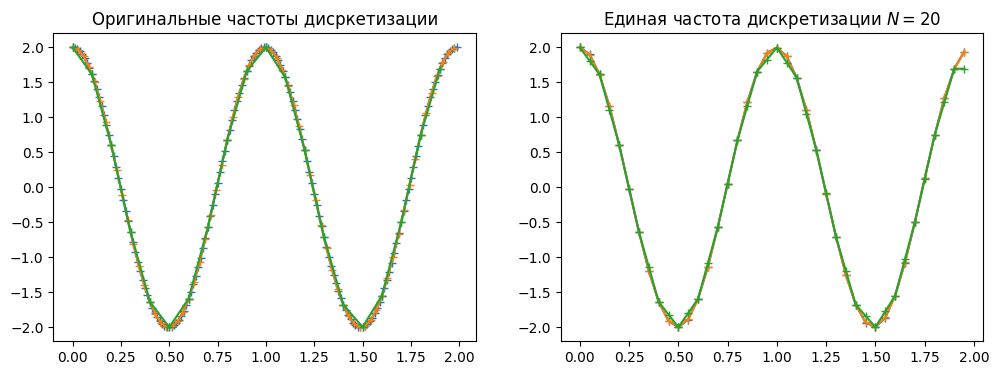

In [17]:
Ns = list(range(1, 101, +1)) + [100]*3 + list(range(100, 19, -1))

for N in Ns:
    mega_rzhaka(N)

---

<br>

*Эхх, моя любимая частота, как её там…*

*А, точно, вспомнил! **Частота Несквика!***

![](https://i.pinimg.com/originals/c2/c0/63/c2c063c0879976d7eacf39a500f02e8c.jpg)